# Transfer Learning Project - Part 1

In [1]:
import os
import os.path as osp
import glob
import shutil
import numpy as np
from numpy import save
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

##### Downloading the dataset via link and extracting it from the zip file

In [2]:
if not(osp.exists("./PetImages")):
  !curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
  !unzip -q kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   330M      0  0:00:02  0:00:02 --:--:--  330M


##### Checking the dataset

In [3]:
print(f"There are {len(glob.glob('./PetImages/Cat/*.jpg'))+len(glob.glob('./PetImages/Dog/*.jpg'))} images including {len(glob.glob('./PetImages/Cat/*.jpg'))} cat, and {len(glob.glob('./PetImages/Dog/*.jpg'))} dog images in the dataset.")

There are 25000 images including 12500 cat, and 12500 dog images in the dataset.


## Data Visualization

In [4]:
base_dir = "./PetImages"
folders = os.listdir(base_dir)
print(folders)

['Dog', 'Cat']


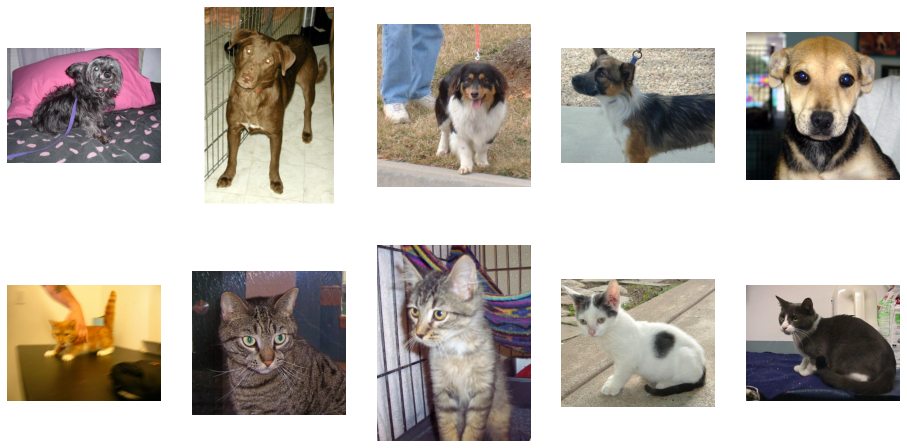

In [5]:
plt.figure(figsize=(16,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    fname = str(i)+".jpg"
    image =  plt.imread(base_dir + "/" + folders[0] + "/" + fname)
    plt.imshow(image)
    plt.axis("off")
    plt.subplot(2,5,i+1+5)
    fname = str(i)+".jpg"
    image =  plt.imread(base_dir + "/" + folders[1] + "/" + fname)
    plt.imshow(image)
    plt.axis("off")

## Data Preprocessing

##### Reading images from the dataset and splitting them into folders

In [6]:
def get_images_labels():
    paths_labels = []
    for image_path in glob.glob("./PetImages/Cat/*.jpg") + glob.glob("./PetImages/Dog/*.jpg"):
        paths_labels.append([image_path, image_path.split('/')[-2]])
    
    paths_labels = np.asarray(paths_labels)
    paths = [i[0] for i in paths_labels]
    labels = [i[1] for i in paths_labels]

    #Splitting dataset into training, validation and test set
    x_train, y_train, x_valid, y_valid, x_test, y_test = split_dataset(np.asarray(paths), np.asarray(labels))

    #Creating directories for each class in the dataset
    if not(osp.exists("./dataset")):
      os.mkdir("./dataset")
      print("Dataset directory is created.")

    x_train = create_directory("./dataset/Training Set", x_train)
    x_valid = create_directory("./dataset/Validation Set", x_valid)
    x_test = create_directory("./dataset/Test Set", x_test)
    shutil.rmtree("./PetImages")
    print("PetImages directory is removed.")

    x_train, y_train = read_images(x_train, y_train)
    x_valid, y_valid = read_images(x_valid, y_valid)
    x_test, y_test = read_images(x_test, y_test)

    print(f"{len(paths)-(len(x_train)+len(x_valid)+len(x_test))} image(s) cannot be read, so they are eliminated from the dataset.")

    return x_train, y_train, x_valid, y_valid, x_test, y_test

In [7]:
def read_images(images, labels):
  images_ = []
  labels_ = []
  for image_path, label in zip(images, labels):
      image = image_preprocessing(image_path)
      if type(image) is not str:
        images_.append(image)
        labels_.append(label)

  return np.asarray(images_), np.asarray(labels_)

##### Creating directories for each class in the dataset

In [8]:
def create_directory(path, images):
    if not(osp.exists(path)):
      os.mkdir(path)
    
    paths = []
    for image in images:
      image_name = image.split('/')[-1]
      label = image.split('/')[-2]
      root = image[:-(len(label) + len(image_name) + 1)]
      new_name = label + '_' + image_name
      os.rename(image, root + new_name)
      shutil.copy(root + new_name, osp.join(path, new_name))
      paths.append(osp.join(path, new_name))

    print(f"{path.split('/')[-1]} directory is created and {len(glob.glob(path + '/*.jpg'))} image(s) are moved inside of it.")

    return np.asarray(paths)

###### Splitting dataset into training(%75), validation(%15) and test set(%10)

In [9]:
def split_dataset(images, labels):
    x_rest, x_test, y_rest, y_test = train_test_split(images, labels, test_size=0.1, random_state=17)    
    x_train, x_valid, y_train, y_valid = train_test_split(x_rest, y_rest, test_size=0.15, random_state=17)

    return x_train, y_train, x_valid, y_valid, x_test, y_test

##### Reading, resizing (128x128) and normalizing the images

In [10]:
def image_preprocessing(image_path):
  try:
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    resized_image = cv2.resize(image, (128, 128), interpolation = cv2.INTER_AREA)
    norm_image = cv2.normalize(resized_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return norm_image
  except:
    return "Invalid"

In [11]:
def main():
    train_dir, valid_dir, test_dir = "./dataset/TrainingSet", "./dataset/ValidationSet", "./dataset/TestSet"
    x_train, y_train, x_valid, y_valid, x_test, y_test = get_images_labels()

    #Checking the training, validation and test directories
    print(f"There are {len(os.listdir('./dataset/Training Set'))} training images, {len(os.listdir('./dataset/Validation Set'))} validation images, and {len(os.listdir('./dataset/Test Set'))} test images.")
    
    print(f"\n----------------------------------------\n"
          f"Checking all the shapes of our data"
          f"x_train: {x_train.shape}\n"
          f"y_train: {y_train.shape}\n"
          f"x_valid: {x_valid.shape}\n"
          f"y_valid: {y_valid.shape}\n"
          f"x_test: {x_test.shape}\n"
          f"y_test: {y_test.shape}\n"
          f"----------------------------------------\n")

    os.mkdir("./data")
    print("Data directory is created.")
    
    #Saving all the splitted sets into numpy files to use them in the second part  
    save('./data/x_train.npy', x_train)
    save('./data/y_train.npy', y_train)
    save('./data/x_valid.npy', x_valid)
    save('./data/y_valid.npy', y_valid)
    save('./data/x_test.npy', x_test)
    save('./data/y_test.npy', y_test)
    print("All images and labels are saved.")

In [12]:
if __name__ == "__main__":
  main()

Dataset directory is created.
Training Set directory is created and 19125 image(s) are moved inside of it.
Validation Set directory is created and 3375 image(s) are moved inside of it.
Test Set directory is created and 2500 image(s) are moved inside of it.
PetImages directory is removed.
54 image(s) cannot be read, so they are eliminated from the dataset.
There are 19125 training images, 3375 validation images, and 2500 test images.

----------------------------------------
Checking all the shapes of our datax_train: (19080, 128, 128, 3)
y_train: (19080,)
x_valid: (3369, 128, 128, 3)
y_valid: (3369,)
x_test: (2497, 128, 128, 3)
y_test: (2497,)
----------------------------------------

Data directory is created.
All images and labels are saved.


###### Converting data folder to zip file

In [13]:
!zip -r ./data.zip ./data

  adding: data/ (stored 0%)
  adding: data/x_valid.npy (deflated 72%)
  adding: data/x_test.npy (deflated 72%)
  adding: data/y_valid.npy (deflated 97%)
  adding: data/y_train.npy (deflated 98%)
  adding: data/x_train.npy (deflated 72%)
  adding: data/y_test.npy (deflated 97%)


##### Downloading data.zip file

In [ ]:
from google.colab import files

files.download("./data.zip")